<a href="https://colab.research.google.com/github/skhazaei/TensorFlow-repo/blob/master/imdb_conv1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the imdb dataset and split into train and test sets

In [ ]:
import tensorflow_datasets as tfds

imdb, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF326AV/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF326AV/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteF326AV/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


## Take the tokenizer and try some sample string to encode and decode

In [ ]:
tokenizer = info.features['text'].encoder

In [ ]:
sample_string = 'In other words, cats do love you ... \n even if they don\'t show it.\n The research, published in the journal Current Biology,\n found that cats form attachments\n to their owners that are similar to \n those that dogs and even babies \n form with their caregivers.\n'

In [ ]:
tokenized_string = tokenizer.encode(sample_string)
print('tokenized string is: {}'.format(tokenized_string))

tokenized string is: [147, 108, 3165, 2, 871, 8, 110, 174, 151, 2831, 7939, 7961, 78, 75, 53, 109, 7968, 21, 191, 39, 7975, 7939, 7961, 19, 3899, 2, 7192, 6891, 36, 11, 1, 7757, 7961, 2497, 1423, 897, 6291, 7973, 7939, 7961, 321, 13, 871, 8, 1642, 7724, 503, 8044, 7939, 7961, 7, 79, 3386, 8, 13, 29, 1243, 254, 7961, 7939, 7961, 198, 13, 2486, 8, 5, 78, 3196, 737, 7961, 7939, 7961, 1642, 22, 79, 2337, 5822, 690, 7975, 7939]


In [ ]:
original_string = tokenizer.decode(tokenized_string)
print('original string is:\n\n {}'.format(original_string))

original string is:

 In other words, cats do love you ... 
 even if they don't show it.
 The research, published in the journal Current Biology,
 found that cats form attachments
 to their owners that are similar to 
 those that dogs and even babies 
 form with their caregivers.



In [ ]:
for ts in tokenized_string:
  print('{}---->{}'.format(ts, tokenizer.decode([ts])))

147---->In 
108---->other 
3165---->words
2---->, 
871---->cat
8---->s 
110---->do 
174---->love 
151---->you
2831----> ... 
7939---->

7961----> 
78---->even 
75---->if 
53---->they 
109---->don
7968---->'
21---->t 
191---->show 
39---->it
7975---->.
7939---->

7961----> 
19---->The 
3899---->research
2---->, 
7192---->pub
6891---->lish
36---->ed 
11---->in 
1---->the 
7757---->journal
7961----> 
2497---->Cur
1423---->rent 
897---->Bi
6291---->ology
7973---->,
7939---->

7961----> 
321---->found 
13---->that 
871---->cat
8---->s 
1642---->form 
7724---->attach
503---->ment
8044---->s
7939---->

7961----> 
7---->to 
79---->their 
3386---->owner
8---->s 
13---->that 
29---->are 
1243---->similar 
254---->to
7961----> 
7939---->

7961----> 
198---->those 
13---->that 
2486---->dog
8---->s 
5---->and 
78---->even 
3196---->bab
737---->ies
7961----> 
7939---->

7961----> 
1642---->form 
22---->with 
79---->their 
2337---->care
5822---->giv
690---->ers
7975---->.
7939---->



## Prepare `train_dataset` and `test_dataset` using `shuffle()` and `padded_batch()`

In [ ]:
import tensorflow as tf

train_dataset = train_data.shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(batch_size=64, padded_shapes=tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(batch_size=64, padded_shapes=tf.compat.v1.data.get_output_shapes(test_data))

## Define the model using a convolutional network, in which the words will be grouped into the size of filter; in this case 5. The number of filters is 128.

In [ ]:
max_length = 120

model = tf.keras.models.Sequential([tf.keras.layers.Embedding(tokenizer.vocab_size, 64, input_length=max_length),
                                    tf.keras.layers.Conv1D(128, 5, activation='relu'),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 64)           523840    
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


## Note that as the size of `input_length=120` words, and a filter that is 5 words long will shave off 2 words from the front and back, leaving us with 116.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=2)

Epoch 1/50
391/391 - 50s - loss: 0.4535 - accuracy: 0.7753 - val_loss: 0.3161 - val_accuracy: 0.8724
Epoch 2/50
391/391 - 26s - loss: 0.2242 - accuracy: 0.9157 - val_loss: 0.3101 - val_accuracy: 0.8736
Epoch 3/50
391/391 - 23s - loss: 0.1716 - accuracy: 0.9382 - val_loss: 0.3290 - val_accuracy: 0.8751
Epoch 4/50
391/391 - 22s - loss: 0.1365 - accuracy: 0.9526 - val_loss: 0.3777 - val_accuracy: 0.8661
Epoch 5/50
391/391 - 22s - loss: 0.1110 - accuracy: 0.9618 - val_loss: 0.4264 - val_accuracy: 0.8648
Epoch 6/50
391/391 - 21s - loss: 0.0902 - accuracy: 0.9699 - val_loss: 0.5035 - val_accuracy: 0.8561
Epoch 7/50
391/391 - 20s - loss: 0.0710 - accuracy: 0.9770 - val_loss: 0.5465 - val_accuracy: 0.8531
Epoch 8/50
391/391 - 21s - loss: 0.0595 - accuracy: 0.9820 - val_loss: 0.6026 - val_accuracy: 0.8530
Epoch 9/50
391/391 - 20s - loss: 0.0414 - accuracy: 0.9882 - val_loss: 0.7576 - val_accuracy: 0.8554
Epoch 10/50
391/391 - 20s - loss: 0.0362 - accuracy: 0.9895 - val_loss: 0.8081 - val_accura

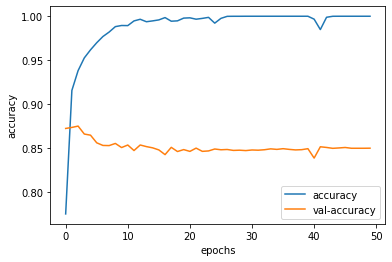

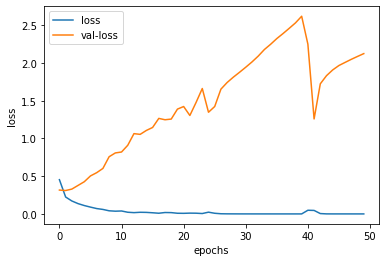

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val-'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Let's try the model without setting the `max_length=120`

In [ ]:
model_2 = tf.keras.models.Sequential([tf.keras.layers.Embedding(tokenizer.vocab_size, 64),
                                    tf.keras.layers.Conv1D(128, 5, activation='relu'),
                                    tf.keras.layers.GlobalAveragePooling1D(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         41088     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 573,249
Trainable params: 573,249
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_dataset, epochs=50, validation_data=test_dataset, verbose=2)

Epoch 1/50
391/391 - 20s - loss: 0.4492 - accuracy: 0.7749 - val_loss: 0.3005 - val_accuracy: 0.8774
Epoch 2/50
391/391 - 19s - loss: 0.2200 - accuracy: 0.9174 - val_loss: 0.3091 - val_accuracy: 0.8747
Epoch 3/50
391/391 - 19s - loss: 0.1721 - accuracy: 0.9366 - val_loss: 0.3221 - val_accuracy: 0.8722
Epoch 4/50
391/391 - 19s - loss: 0.1365 - accuracy: 0.9531 - val_loss: 0.3580 - val_accuracy: 0.8694
Epoch 5/50
391/391 - 19s - loss: 0.1126 - accuracy: 0.9608 - val_loss: 0.3947 - val_accuracy: 0.8640
Epoch 6/50
391/391 - 19s - loss: 0.0862 - accuracy: 0.9715 - val_loss: 0.4604 - val_accuracy: 0.8624
Epoch 7/50
391/391 - 19s - loss: 0.0711 - accuracy: 0.9770 - val_loss: 0.5506 - val_accuracy: 0.8565
Epoch 8/50
391/391 - 20s - loss: 0.0544 - accuracy: 0.9836 - val_loss: 0.6731 - val_accuracy: 0.8496
Epoch 9/50
391/391 - 19s - loss: 0.0405 - accuracy: 0.9883 - val_loss: 0.8001 - val_accuracy: 0.8512
Epoch 10/50
391/391 - 19s - loss: 0.0392 - accuracy: 0.9877 - val_loss: 0.7686 - val_accura

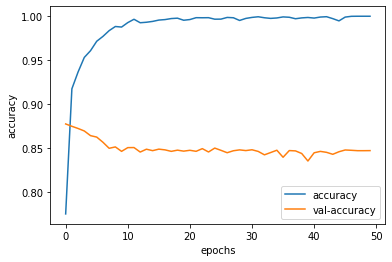

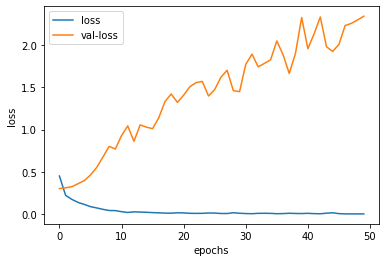

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val-'+string])
  plt.show()

plot_graphs(history_2, 'accuracy')
plot_graphs(history_2, 'loss')

As it can be seen, our accuracy does even better than LSTM model with close to about 100% on training and around 80% on validation. But as before, our loss increases in the validation set, indicating potential overfilling. As we have a super simple network here, it's not surprising, and it will take some experimentation with different combinations of conversational layers to improve on this.